<a href="https://colab.research.google.com/github/TharinduMadhusanka/sri-lanka-climate-zones/blob/main/Mapping_Climate%C2%A0Zones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os

# Define the directory where you want to download the dataset
download_dir = "/content/mydataset"  # Example: downloads to /content/mydataset

path = kagglehub.dataset_download("tharindumadhusanka9/sri-lanka-subnational-administrative-boundaries")

print("Path to dataset files:", path)


100%|██████████| 140M/140M [00:05<00:00, 29.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tharindumadhusanka9/sri-lanka-subnational-administrative-boundaries/versions/1


In [2]:
import shutil
import os

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# Iterate through all items in the source path
for item in os.listdir(path):
    source_item = os.path.join(path, item)  # Get full path of source item
    destination_item = os.path.join(download_dir, item)  # Get full path of destination item

    # Move the item to the destination directory
    shutil.move(source_item, destination_item)

print(f"Files moved from '{path}' to '{download_dir}'")

Files moved from '/root/.cache/kagglehub/datasets/tharindumadhusanka9/sri-lanka-subnational-administrative-boundaries/versions/1' to '/content/mydataset'


In [3]:
import folium
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from IPython.display import display
from folium import Map, Marker
from folium.plugins import MarkerCluster

# Define latitude and longitude bounds for Sri Lanka and grid size
lat_min, lat_max = 5.9, 9.9
lon_min, lon_max = 79.7, 81.9
lat_points, lon_points = 30, 30

# Generate grid of unfiltered coordinates
lat_values = np.linspace(lat_min, lat_max, lat_points)
lon_values = np.linspace(lon_min, lon_max, lon_points)
coordinates = [(lat, lon) for lat in lat_values for lon in lon_values]

# Load the Sri Lanka shapefile to filter coordinates within landmass
shapefile_path = '/content/mydataset/lka_admbnda_adm0_slsd_20220816.shp'  # Replace with your path in Colab
sri_lanka = gpd.read_file(shapefile_path)

# Convert coordinates to GeoDataFrame and filter
points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in coordinates], crs="EPSG:4326")
points_in_sri_lanka = gpd.sjoin(points, sri_lanka, predicate='within')  # Use predicate instead of op
filtered_coordinates = [(point.y, point.x) for point in points_in_sri_lanka.geometry]


In [4]:
# 1. Map with Unfiltered Coordinates
unfiltered_map = folium.Map(location=[7.87, 80.65], zoom_start=7)  # Centered on Sri Lanka
marker_cluster_unfiltered = MarkerCluster().add_to(unfiltered_map)

# Add each unfiltered coordinate as a marker on the map
for lat, lon in coordinates:
    folium.Marker(location=[lat, lon], icon=folium.Icon(color="red", icon="info-sign")).add_to(marker_cluster_unfiltered)

# Display the unfiltered map
display(unfiltered_map)



In [6]:
# 2. Map with Filtered Coordinates
filtered_map = folium.Map(location=[7.87, 80.65], zoom_start=7)  # Centered on Sri Lanka
marker_cluster_filtered = MarkerCluster().add_to(filtered_map)

# Add each filtered coordinate as a marker on the map
for lat, lon in filtered_coordinates:
    folium.Marker(location=[lat, lon], icon=folium.Icon(color="blue", icon="info-sign")).add_to(marker_cluster_filtered)

# Display the filtered map
display(filtered_map)


In [7]:
len(filtered_coordinates)

520

## Get data from Open Meteo API


You dont need to get data running this cell unless you want new data. I have provided the data set. you can download it directily.

In [ ]:
!pip install -qq openmeteo-requests requests-cache retry_requests

API Usage Notice: This notebook uses the Open-Meteo API, which is a free service. To avoid exceeding rate limits and potential service disruption for all users, please refrain from making unnecessary or excessively frequent API calls. Consider implementing caching or other strategies to minimize API usage.


In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import time

# Define latitudes and longitudes from filtered_coordinates
latitudes = [coord[0] for coord in filtered_coordinates]
longitudes = [coord[1] for coord in filtered_coordinates]

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
daily_vars = ["temperature_2m_max", "temperature_2m_min", "precipitation_sum",]
url = "https://archive-api.open-meteo.com/v1/archive"

# Function to process data for each batch of coordinates
def fetch_weather_data(latitudes, longitudes):
    weather_data = []

    # Split the latitudes and longitudes into smaller chunks for API requests
    batch_size = 100  # Adjust batch size if needed
    for i in range(0, len(latitudes), batch_size):
        batch_lats = latitudes[i:i + batch_size]
        batch_lons = longitudes[i:i + batch_size]

        params = {
            "latitude": batch_lats,
            "longitude": batch_lons,
            "start_date": "2022-11-11",
            "end_date": "2024-11-11",
            "daily": daily_vars,
            "timezone": "Asia/Calcutta"
        }
        responses = openmeteo.weather_api(url, params=params)
        print("waiting for 60 seconds")
        time.sleep(60)


        for idx, response in enumerate(responses):
            # Process daily data for each location in the batch
            daily = response.Daily()
            daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
            daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
            daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

            # Prepare the daily data
            daily_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=daily.Interval()),
                    inclusive="left"
                ),
                "latitude": batch_lats[idx],
                "longitude": batch_lons[idx],
                "temperature_2m_max": daily_temperature_2m_max,
                "temperature_2m_min": daily_temperature_2m_min,
                "precipitation_sum": daily_precipitation_sum,
            }

            # Create DataFrame for this location and append to the final list
            weather_data.append(pd.DataFrame(data=daily_data))

        print(f"Batch {i // batch_size + 1} processed. Time left: {len(latitudes) - (i + batch_size)} locations remaining.")

    # Concatenate all DataFrames into a single DataFrame
    return pd.concat(weather_data, ignore_index=True)

# Fetch data and create final DataFrame
df = fetch_weather_data(latitudes, longitudes)

# Save the final DataFrame to a CSV file
df.to_csv("climate_data_sri_lanka_full.csv", index=False)

# Show a preview of the first few rows
print(df.head())


## Get the data  already created dataset
I already created dataset. you can use it.

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tharindumadhusanka9/sri-lanka-climate-data")

print("Path to dataset files:", path)



100%|██████████| 2.88M/2.88M [00:00<00:00, 4.45MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tharindumadhusanka9/sri-lanka-climate-data/versions/1


In [13]:
# move it to mydataset
import shutil
shutil.move(path, "/content/mydataset")

'/content/mydataset/1'

## Clustering

In [11]:
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np

In [14]:
df = pd.read_csv("/content/mydataset/1/Sri_Lanka_Climate_Data.csv")

df['date'] = pd.to_datetime(df['date']).dt.date
df['temperature_2m_avg'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2

shapefile_path = '/content/mydataset/lka_admbnda_adm0_slsd_20220816.shp'
country_map = gpd.read_file(shapefile_path)

In [15]:
df.head()

,date,latitude,longitude,temperature_2m_max,temperature_2m_min,precipitation_sum,temperature_2m_avg
0,2022-11-11,6.066667,80.231034,28.7975,24.4975,1.000000,26.6475
1,2022-11-12,6.066667,80.231034,27.7475,23.2975,17.800001,25.5225
2,2022-11-13,6.066667,80.231034,26.6475,23.2475,13.599999,24.9475
3,2022-11-14,6.066667,80.231034,28.1475,22.8975,17.900002,25.5225
4,2022-11-15,6.066667,80.231034,28.3475,22.6475,23.499998,25.4975


In [16]:
features = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'temperature_2m_avg']

# Select the relevant columns
data_for_clustering = df[features]

# 3. Scale the features (important for K-Means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

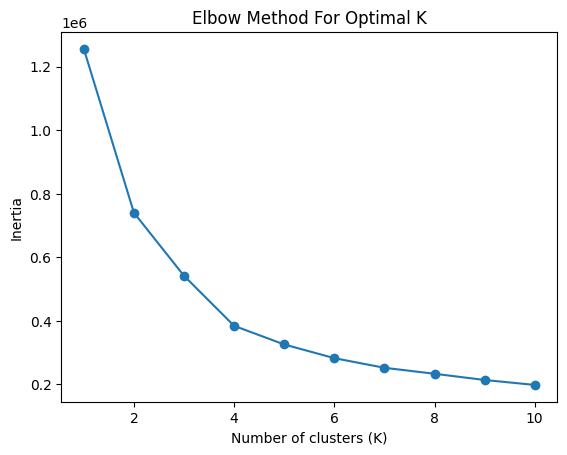

In [17]:
# Elbow Method for optimal number of clusters
inertia = []  # List to store the inertia values for different K values
for k in range(1, 11):  # Testing K values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph to determine the best K
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.show()

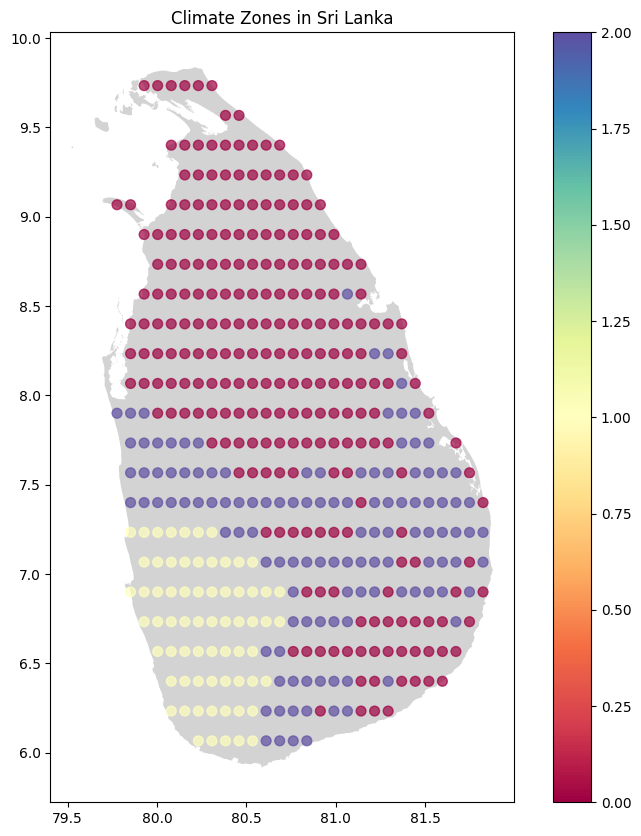

   latitude  longitude  cluster
0  6.066667  80.231034        1
1  6.066667  80.306897        1
2  6.066667  80.382759        1
3  6.066667  80.458621        1
4  6.066667  80.534483        1


In [18]:
coordinates = df[['latitude', 'longitude']].drop_duplicates()

# Assuming the relevant climate variables are in 'temperature_2m_max', 'temperature_2m_min', and 'precipitation_sum'
climate_data = df.groupby(['latitude', 'longitude']).agg({
    'temperature_2m_max': 'mean',
    'temperature_2m_min': 'mean',
    'temperature_2m_avg': 'mean',
    'precipitation_sum': 'sum'

}).reset_index()

# 2. Scale the data for clustering
scaler = StandardScaler()
climate_features = climate_data[[
                                # 'temperature_2m_max',
                                #  'temperature_2m_min',
                                 'precipitation_sum',
                                # 'temperature_2m_avg',
                                 ]]
scaled_features = scaler.fit_transform(climate_features)

# 3. Apply K-Means clustering to categorize the climate zones (for example: 5 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
climate_data['cluster'] = kmeans.fit_predict(scaled_features)

# 4. Create a GeoDataFrame for visualization
# Create Point geometry from latitude and longitude
geometry = [Point(lon, lat) for lon, lat in zip(climate_data['longitude'], climate_data['latitude'])]
gdf = gpd.GeoDataFrame(climate_data, geometry=geometry)


# 5. Plot the Sri Lanka map with climate zones
fig, ax = plt.subplots(figsize=(10, 10))
country_map.plot(ax=ax, color='lightgray')  # Plot the country boundary
gdf.plot(ax=ax, column='cluster', cmap="Spectral" , legend=True, marker='o', markersize=50, alpha=0.7)
ax.set_title('Climate Zones in Sri Lanka')
plt.show()

# 6. Display the clustered data with locations
# Each row will now have a cluster representing the climate zone
print(climate_data[['latitude', 'longitude', 'cluster']].head())

# Optionally save the results to a CSV file
# climate_data[['latitude', 'longitude', 'cluster']].to_csv('climate_zones_sri_lanka.csv', index=False)


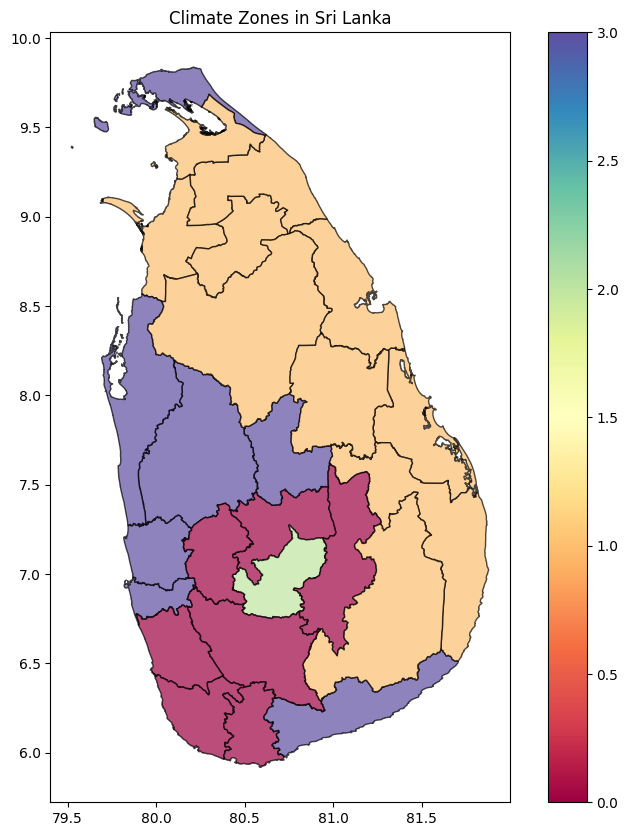

In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from shapely.geometry import Point

df = pd.read_csv("/content/mydataset/1/Sri_Lanka_Climate_Data.csv")

df['date'] = pd.to_datetime(df['date']).dt.date
df['temperature_2m_avg'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2

shapefile_path = '/content/mydataset/lka_admbnda_adm2_slsd_20220816.shp'
country_map = gpd.read_file(shapefile_path)


# Group climate data by latitude and longitude
climate_data = df.groupby(['latitude', 'longitude']).agg({
    'temperature_2m_max': 'mean',
    'temperature_2m_min': 'mean',
    'precipitation_sum': 'sum'
}).reset_index()

# 2. Scale the data for clustering
scaler = StandardScaler()
selected_feature = 'temperature_2m_max'
climate_features = climate_data[[selected_feature]]  # Select the feature(s) for clustering
scaled_features = scaler.fit_transform(climate_features)

# 3. Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
climate_data['cluster'] = kmeans.fit_predict(scaled_features)

# 4. Create GeoDataFrame for clusters
geometry = [Point(lon, lat) for lon, lat in zip(climate_data['longitude'], climate_data['latitude'])]
gdf = gpd.GeoDataFrame(climate_data, geometry=geometry, crs="EPSG:4326")  # Set appropriate CRS


# 5. Perform a spatial join to associate clusters with districts
gdf_sjoin = gpd.sjoin(gdf, country_map, how='left', predicate='within')

# Aggregate cluster data at the district level
district_clusters = gdf_sjoin.groupby('ADM2_EN')['cluster'].agg(lambda x: x.mode()[0]).reset_index()

# Merge the aggregated clusters back into the shapefile
country_map = country_map.merge(district_clusters, on='ADM2_EN', how='left')

# 6. Plot the map with filled clusters
fig, ax = plt.subplots(figsize=(10, 10))
country_map.plot(ax=ax, column='cluster', cmap="Spectral", legend=True, edgecolor='black', alpha=0.7)
ax.set_title('Climate Zones in Sri Lanka')
plt.show()


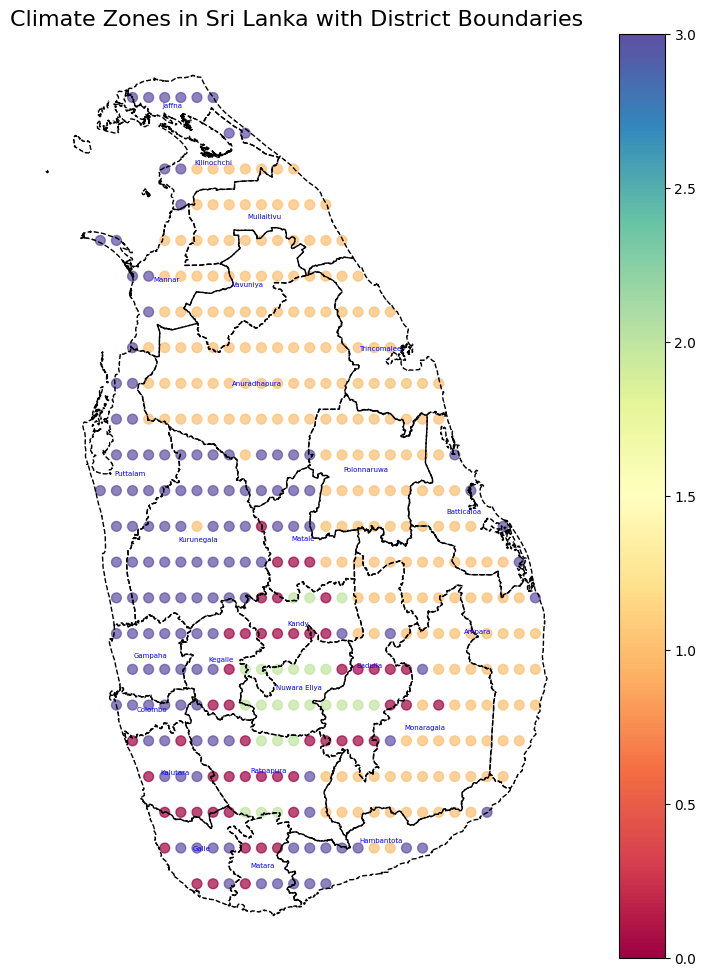

In [23]:
# -----------------------------------------------------------------------------------------
# 5. Plot the Sri Lanka map with climate zones and highlighted district boundaries
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the country boundaries with district borders
country_map.boundary.plot(ax=ax, linewidth=1.0, edgecolor='black', linestyle='--')  # District boundaries

# Plot the climate zones
gdf.plot(
    ax=ax,
    column='cluster',
    cmap="Spectral",
    legend=True,
    marker='o',
    markersize=50,
    alpha=0.7
)

# Add labels for each district (optional)
for _, row in country_map.iterrows():
    # Extract the centroid of each district
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['ADM2_EN'], fontsize=5, ha='center', color='blue')  # Customize label field and style

# Add title and improve layout
ax.set_title('Climate Zones in Sri Lanka with District Boundaries', fontsize=16)
ax.set_axis_off()  # Remove axis for better visualization

plt.show()

In [22]:
!pip install rasterio -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.0 MB/s eta 0:00:00


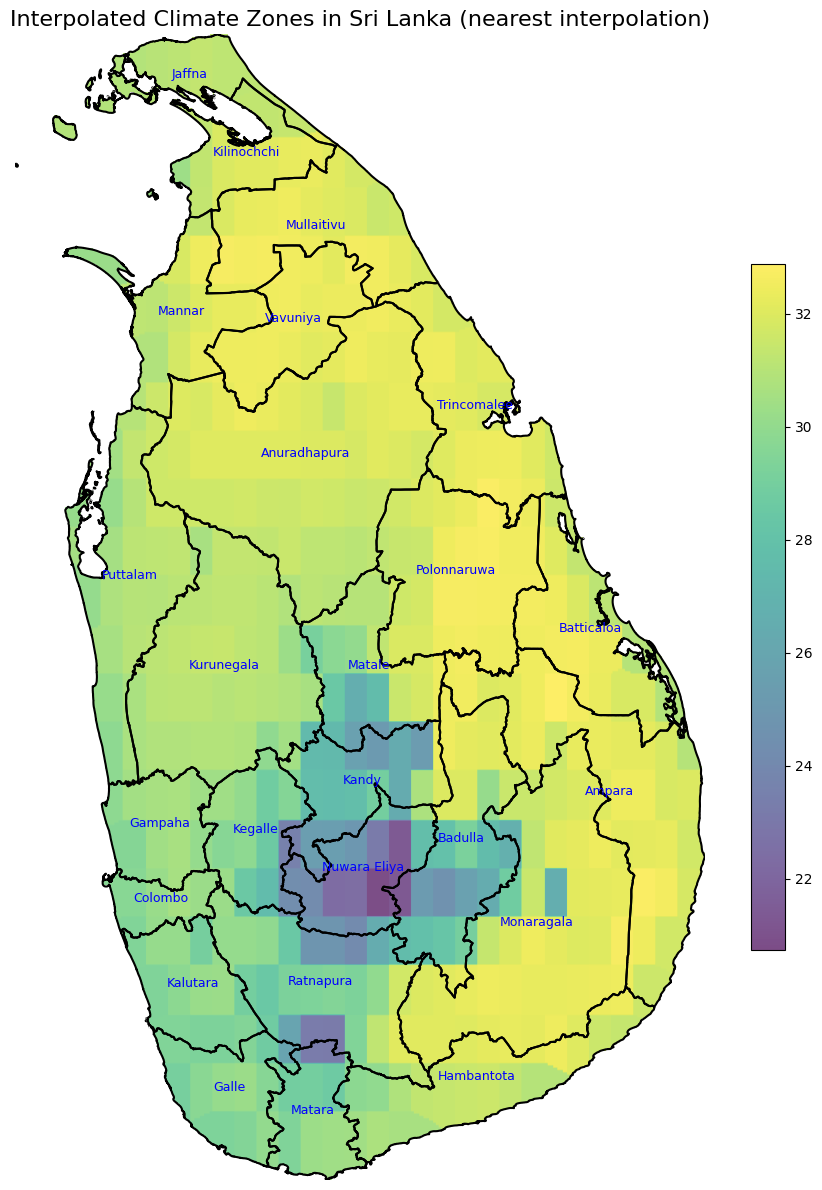

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.ndimage as ndimage
import rasterio.features

def interpolate_with_gap_filling(gdf, country_map, selected_feature, interpolation_method='cubic'):
    # Get the country boundaries
    lon_min, lat_min, lon_max, lat_max = country_map.total_bounds

    # Create a denser grid
    grid_lon, grid_lat = np.meshgrid(
        np.linspace(lon_min, lon_max, 500),  # High resolution
        np.linspace(lat_min, lat_max, 500)   # High resolution
    )

    # Prepare input data for interpolation
    input_points = gdf[['longitude', 'latitude']].values
    input_values = gdf[selected_feature].values

    # Initial interpolation
    interpolated_values = griddata(
        points=input_points,
        values=input_values,
        xi=(grid_lon, grid_lat),
        method=interpolation_method
    )

    # Combine all geometries into one using `union_all`
    sri_lanka_boundary = country_map.geometry.union_all()

    # Create a mask for Sri Lanka's boundary
    mask_shape = interpolated_values.shape
    transform = [  # Affine transform for the grid
        (lon_max - lon_min) / mask_shape[1], 0, lon_min,
        0, (lat_max - lat_min) / mask_shape[0], lat_min
    ]

    # Create mask with boundary
    mask = rasterio.features.geometry_mask(
        [sri_lanka_boundary],
        transform=transform,
        out_shape=mask_shape,
        invert=True,
        all_touched=True
    )

    # Identify nan values within the mask
    nan_mask = np.isnan(interpolated_values) & mask

    # Fill methods to try
    if np.any(nan_mask):
        # 1. Nearest neighbor filling
        filled_values = griddata(
            points=input_points,
            values=input_values,
            xi=(grid_lon, grid_lat),
            method='nearest'
        )

        # Replace nan values with nearest neighbor interpolation
        interpolated_values[nan_mask] = filled_values[nan_mask]

        # 2. If still some nans, use scipy's gaussian filter for smooth interpolation
        if np.any(np.isnan(interpolated_values)):
            # Temporarily replace nans with a smoothed version
            temp_values = interpolated_values.copy()

            # Smooth the data
            smooth_values = ndimage.gaussian_filter(
                np.nan_to_num(temp_values, nan=np.nanmean(temp_values)),
                sigma=10  # Adjust sigma for more or less smoothing
            )

            # Fill remaining nans with smoothed values
            nan_indices = np.isnan(temp_values)
            interpolated_values[nan_indices] = smooth_values[nan_indices]

    # Apply final mask to ensure only Sri Lanka area is shown
    masked_values = np.ma.masked_array(
        interpolated_values,
        mask=~mask
    )

    return grid_lon, grid_lat, masked_values

def plot_interpolated_climate_map(gdf, country_map, selected_feature, interpolation_method='cubic'):
    # Perform interpolation with gap filling
    grid_lon, grid_lat, interpolated_values = interpolate_with_gap_filling(
        gdf, country_map, selected_feature, interpolation_method
    )

    # Get country boundaries
    lon_min, lat_min, lon_max, lat_max = country_map.total_bounds

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot district boundaries
    country_map.boundary.plot(ax=ax, linewidth=1.5, edgecolor='black')

    # Overlay the continuous gradient
    c = ax.imshow(
        interpolated_values,
        extent=(lon_min, lon_max, lat_min, lat_max),
        origin='lower',
        cmap='viridis',
        alpha=0.7
    )

    # Add a color bar
    cbar = plt.colorbar(c, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)

    # Optionally add district labels
    for _, row in country_map.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row['ADM2_EN'],
                fontsize=9, ha='center', color='blue')

    # Set title and remove axes
    ax.set_title(f'Interpolated Climate Zones in Sri Lanka ({interpolation_method} interpolation)', fontsize=16)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Usage example
plot_interpolated_climate_map(gdf, country_map, selected_feature='temperature_2m_max', interpolation_method='nearest')


In [28]:
image_url = 'https://www.meteo.gov.lk/images/climate/annual_temratures.png'

from IPython.display import Image
Image(url=image_url, width=500)